In [1]:
import yt
yt.set_log_level(50)  
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import trange
from utils import grabFileSeries, get_simulation_time, change_in_box
from utils import draw_xy_box, parse_input_file, div2D, dFdx, dFdy, rolling_average
from utils import dFdx_1d_non_U_grid, dFdy_1d_non_U_grid, dFdx_mesh, dFdy_mesh, derivative1d_on_mesh

In [3]:
# Standard dataset initialization
index = 48
scratch_dirname = "vary_eta_force_free_IC/1e-7/"
# scratch_dirname = "forcetest/"
inputname = "athinput.recon_gauss_harris"
input_params = parse_input_file(f'/mnt/gs21/scratch/freem386/{scratch_dirname}{inputname}')
fileseries = grabFileSeries(scratch_dirname, index, basename="recon_fast")
ts = yt.DatasetSeries(fileseries)
time = get_simulation_time(fileseries[index])
ds = ts[index]

In [11]:
# Casting yt data into numpy data to analyze
# Defining analysis box limits (in code units of x and y)
xminbox, xmaxbox = -1.2, 1.2
yminbox, ymaxbox = -0.1, 0.1

# Creating the covering grid using YT to cast yt data
level = input_params["refinement1_level"]   # Max refinement level - highest resolution needed for numpy array
Nx = input_params["mesh_nx1"] * 2**(level)  # Nx, Ny is the number of cells in each direction of the WHOLE simulation domain
Ny = input_params["mesh_nx2"] * 2**(level)
xmin, xmax = input_params["mesh_x1min"], input_params["mesh_x1max"] # This is the dimension of the WHOLE simulation domain
ymin, ymax = input_params["mesh_x2min"], input_params["mesh_x2max"]
dx, dy = (xmax - xmin)/Nx, (ymax - ymin)/Ny     # grid resolution at highest refinement level
i0, j0 = int(np.floor((xminbox -  xmin  )//dx)), int(np.floor((yminbox -  ymin  )//dy))     # Index for starting x and y positions within the covering grid
iN, jN = int(np.floor((xmaxbox - xminbox)//dx)), int(np.floor((ymaxbox - yminbox)//dy))   # Length of the covering grid data in x/y

# Finally the real covering grid:
cg = ds.covering_grid(level=level, left_edge=[xminbox, yminbox, 0], dims=[iN, jN, 1])
# Grabbing mesh information using numpy
X, Y = np.reshape(cg["athena_pp","x"].v, (iN, jN)), np.reshape(cg["athena_pp","y"].v, (iN, jN))
x = X[:,0]
y = Y[0,:]

# Now grab relevant fluid quantities (sliced along x, y, then reducing dimension with [...,0], elminating YT units with .v)
Bx = cg["gas", "magnetic_field_x"][:,:,0].v
By = cg["gas", "magnetic_field_y"][:,:,0].v

dBydx = dFdx_mesh(By, x)
dBxdy = dFdy_mesh(Bx, y)
curlB = dBydx - dBxdy
field = curlB

<Figure size 640x480 with 0 Axes>

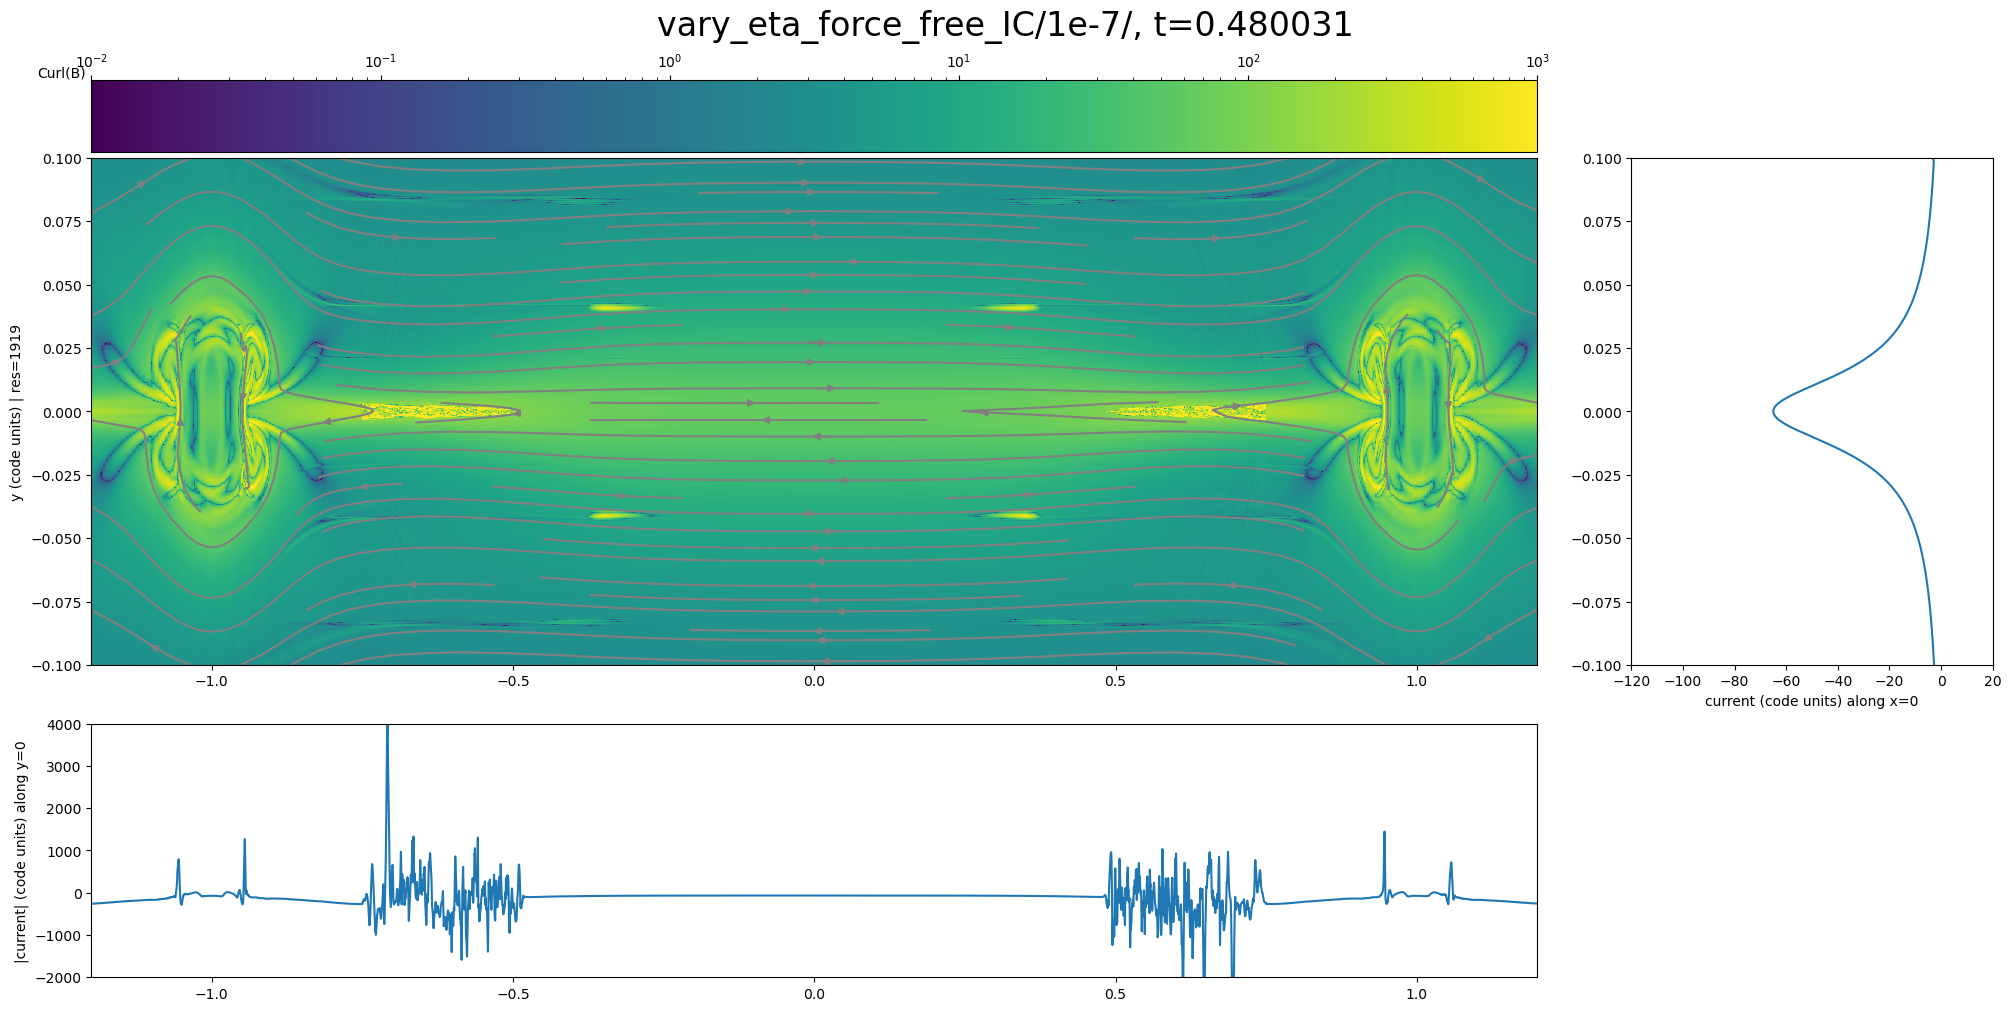

In [12]:
plt.clf() # Found to be effective to get rid of weird plots floating around

# Four total subplots (bottom right is deleted), largest in the top left, and thin on the right column and bottom row
gs_kw = dict(width_ratios=[1.0, 0.25], height_ratios=[1.0, 0.5])    # Gridspec (gs) keywords for defining subplots
fig, ax = plt.subplots(2, 2, gridspec_kw=gs_kw, layout='constrained')
fig.delaxes(ax[1,1]);  # Delete unused axis (bottom right)

# current colormesh, colorbar, magnetic field streamplot (top left plot)
p1 = ax[0,0].pcolormesh(X, Y, np.abs(field), norm=colors.LogNorm(vmin=1e-2, vmax=1e3))
cbar = plt.colorbar(p1, location="top", pad=0)
ax[0,0].streamplot(x, y, Bx.T, By.T, color="gray")
# ax[0,0].quiver(x[::iN//40], y[::jN//20], vx[::iN//40,::jN//20].T, vy[::iN//40,::jN//20].T, color="black", scale=20)
# ax[0,0].contour(X, Y, field, colors="black", levels=50)
cbar.ax.set_ylabel(f"Curl(B)", rotation=0, loc="top")
ax[0,0].set_ylabel(f"y (code units) | res={Y.shape[1]}")

# y=0 slice (middle bottom left plot)
ax[1,0].plot(X[:,jN//2], field[:,jN//2])
ax[1,0].set_ylabel(f"|current| (code units) along y=0")
ax[1,0].set_ylim(-2000, 4000)
# ax[1,0].set_yscale("log")

# x=0 slice (middle top right)
ax[0,1].plot(field[iN//2,:], Y[iN//2,:])
ax[0,1].set_xlabel(f"current (code units) along x=0")
ax[0,1].set_xlim(-120, 20)

# Force axes to match:
for i in range(2): ax[i, 0].set_xlim(xminbox, xmaxbox)
for j in range(2): ax[0, j].set_ylim(yminbox, ymaxbox)

# Supertitle
fig.suptitle(f"{scratch_dirname}, t={time:.6f}", fontsize=24)
fig.set_size_inches(20, 10)

fig.show()

In [29]:
fig.savefig("figures/ve1e-5_curlB_i100.png")

2.374e-30, 1.099e-09, 9.811e-20
-inf, -inf, -inf


/tmp/ipykernel_4091302/3126867916.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  r_squaredg, r_squaredt, r_squareds = 1 - ss_resg/ss_tot, 1-ss_rest/ss_tot, 1-ss_ress/ss_tot


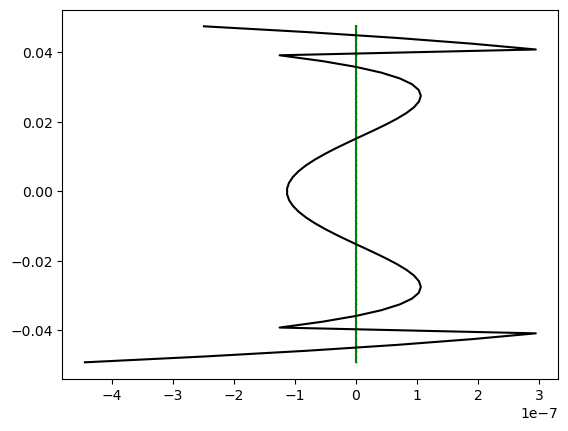

In [20]:
# Actually fitting the data:
def funcg(x, A, mu, sig, c):
    return A*np.exp(-((x-mu)/sig)**2) + c

def funct(x, A, mu, sig, w, c):
    return c + 0.5*A*(1 - np.tanh(np.abs((x-mu)/sig) -w))

def funcs(x, A, mu, d, c, b, w):
    return c + A/2*(np.abs(x-mu+d)/(x-mu+d) - np.abs(x-mu-d)/(x-mu-d)) + b*x**2 + w*x**4

# Standard dataset initialization
index = 100
# scratch_dirname = "vary_eta/eta_1e-3/"
scratch_dirname = "forcetest/"
# inputname = "athinput.recon_gauss_harris"
input_params = parse_input_file(f'/mnt/gs21/scratch/freem386/{scratch_dirname}{inputname}')
fileseries = grabFileSeries(scratch_dirname, index, basename="recon_fast")
ts = yt.DatasetSeries(fileseries)
time = get_simulation_time(fileseries[index])
ds = ts[index]

# Finally the real covering grid:
cg = ds.covering_grid(level=level, left_edge=[xminbox, yminbox, 0], dims=[iN, jN, 1])
# Grabbing mesh information using numpy
X, Y = np.reshape(cg["athena_pp","x"].v, (iN, jN)), np.reshape(cg["athena_pp","y"].v, (iN, jN))
x = X[:,0]
y = Y[0,:]

# Now grab relevant fluid quantities (sliced along x, y, then reducing dimension with [...,0], elminating YT units with .v)
vx = cg["gas", "velocity_x"][:,:,0].v
vy = cg["gas", "velocity_y"][:,:,0].v
Bx = cg["gas", "magnetic_field_x"][:,:,0].v
By = cg["gas", "magnetic_field_y"][:,:,0].v
rho = cg["gas", "density"][:,:,0].v


# Ez = u x B = eta*Jz, so current is:
# J = (vx*By - vy*Bx) / input_params["problem_eta_ohm"]
J = rho
# dJdy = dFdy(J, y)

j_slice = J[iN//2,:]
param_boundsg = ([-np.inf, -1, 0, -np.inf], [np.inf, 1, np.inf, np.inf])
param_boundst = ([-np.inf, -1, 0, -np.inf, -np.inf], [np.inf, 1, np.inf, np.inf, np.inf])
param_boundss = ([-np.inf, -1, -np.inf, -np.inf, -np.inf, -np.inf], [np.inf, 1, np.inf, np.inf, np.inf, np.inf])
poptg, pcovg = curve_fit(funcg, y, j_slice, bounds=param_boundsg, maxfev=1e7) # p0=[-1, 0, .01, 0.0]
poptt, pcovt = curve_fit(funct, y, j_slice, bounds=param_boundst, maxfev=1e7)
popts, pcovs = curve_fit(funcs, y, j_slice, bounds=param_boundss, maxfev=1e7, p0=[-9e4, 0, 4e-2, 1e5, 100, 0])

plt.scatter(j_slice, y, s=0.1, c="red")
plt.plot(funcg(y, *poptg), y, c="green")
# plt.plot(funct(y, *poptt), y, c="blue")
plt.plot(funcs(y, *popts), y, c="black")

# Calculate chi-squared
residualsg = j_slice - funcg(y, *poptg)
residualst = j_slice - funct(y, *poptt)
residualss = j_slice - funcs(y, *popts)
ss_resg, ss_rest, ss_ress = np.sum(residualsg**2), np.sum(residualst**2), np.sum(residualss**2)
ss_tot = np.sum((j_slice-np.mean(j_slice))**2)
r_squaredg, r_squaredt, r_squareds = 1 - ss_resg/ss_tot, 1-ss_rest/ss_tot, 1-ss_ress/ss_tot
chi_squaredg = np.sum((residualsg / np.std(y))**2)
chi_squaredt = np.sum((residualst / np.std(y))**2)
chi_squareds = np.sum((residualss / np.std(y))**2)
print(f"{chi_squaredg:.3e}, {chi_squareds:.3e}, {chi_squaredt:.3e}")
print(f"{r_squaredg:.4e}, {r_squaredt:.4e}, {r_squareds:.4e}")
# plt.plot([np.min(j_slice), np.max(j_slice)], [-fwhm, -fwhm])
# plt.plot([np.min(j_slice), np.max(j_slice)], [-fwhm, -fwhm])
# print(pcovg)

In [33]:
1/0
# Calculating aspect ratio of force-free sheet
# Standard dataset initialization
max_index = 120
scratch_dirname = "forcetest/"
# scratch_dirname = "forcetest/"
inputname = "athinput.recon_gauss_harris"
input_params = parse_input_file(f'/mnt/gs21/scratch/freem386/{scratch_dirname}{inputname}')
fileseries = grabFileSeries(scratch_dirname, max_index, basename="recon_fast")
ts = yt.DatasetSeries(fileseries)

# Actually fitting the data:
def funcg(x, A, mu, sig, c):
    return A*np.exp(-((x-mu)/sig)**2) + c
print(f"time \t, fwhm gauss rho, J length, Bfrac length, current L/d, Bfrac L/d")

for index in range(10, max_index):
    time = get_simulation_time(fileseries[index])
    ds = ts[index]

    # Casting yt data into numpy data to analyze
    # Defining analysis box limits (in code units of x and y)
    xminbox, xmaxbox = -0, 1.2
    yminbox, ymaxbox = -0.5, 0.5

    # Creating the covering grid using YT to cast yt data

    level = 0 # input_params["refinement1_level"]   # Max refinement level - highest resolution needed for numpy array
    Nx = input_params["mesh_nx1"] * 2**(level)  # Nx, Ny is the number of cells in each direction of the WHOLE simulation domain
    Ny = input_params["mesh_nx2"] * 2**(level)
    xmin, xmax = input_params["mesh_x1min"], input_params["mesh_x1max"] # This is the dimension of the WHOLE simulation domain
    ymin, ymax = input_params["mesh_x2min"], input_params["mesh_x2max"]
    dx, dy = (xmax - xmin)/Nx, (ymax - ymin)/Ny     # grid resolution at highest refinement level
    i0, j0 = int(np.floor((xminbox -  xmin  )//dx)), int(np.floor((yminbox -  ymin  )//dy))     # Index for starting x and y positions within the covering grid
    iN, jN = int(np.floor((xmaxbox - xminbox)//dx)), int(np.floor((ymaxbox - yminbox)//dy))   # Length of the covering grid data in x/y

    # Finally the real covering grid:
    cg = ds.covering_grid(level=level, left_edge=[xminbox, yminbox, 0], dims=[iN, jN, 1])
    # Grabbing mesh information using numpy
    X, Y = np.reshape(cg["athena_pp","x"].v, (iN, jN)), np.reshape(cg["athena_pp","y"].v, (iN, jN))
    x = X[:,0]
    y = Y[0,:]

    # Now grab relevant fluid quantities (sliced along x, y, then reducing dimension with [...,0], elminating YT units with .v)
    vx = cg["gas", "velocity_x"][:,:,0].v
    vy = cg["gas", "velocity_y"][:,:,0].v
    Bx = cg["gas", "magnetic_field_x"][:,:,0].v
    By = cg["gas", "magnetic_field_y"][:,:,0].v
    vA = cg["gas", "alfven_speed"][:,:,0].v
    rho =cg["gas", "density"][:,:,0].v

    # Ez = u x B = eta*Jz, so current is:
    J = (vx*By - vy*Bx) / input_params["problem_eta_ohm"]

    # By / |B|
    B = np.sqrt(Bx*Bx + By*By)
    B_ratio = By**2 / B**2 - Bx**2 / B**2
    
    # find width of sheet from current:
    i = 0
    while i <= iN:
        if J[i, jN//2] > 0.5:     # arbitrary threshold to determine nonzero current
            current_L = X[i, jN//2]
            i += iN     # This should kill the loop
        else:
            current_L = 0   # TODO figure out better handling
        i += 1
    
    # find width of sheet from B ratios
    i = 0
    while i <= iN:
        if B_ratio[i, jN//2] > 0:
            Bratio_L = X[i, jN//2]
            i += iN
        else:
            Bratio_L = 0
        i += 1
    
    # find the height of sheet using density fwhm
    rho_slice = rho[iN//2,:]
    param_boundsg = ([-np.inf, -1, 0, -np.inf], [np.inf, 1, np.inf, np.inf])
    poptg, pcovg = curve_fit(funcg, y, rho_slice, bounds=param_boundsg, maxfev=1e7)
    sig = poptg[2]
    dens_d = 2.35 * sig / 2 # FWHM of gaussian (divided by 2 - consistent with N&L 2011)
    
    aspect_current = current_L / dens_d
    aspect_Bratio  = Bratio_L / dens_d
    
    print(f"{time:.5f}, {dens_d:.6f}, {current_L:.6f}, {Bratio_L:.6f}, {aspect_current:.6e}, {aspect_Bratio:.6e}")

ZeroDivisionError: division by zero